# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков и визуальный анализ данных
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *conda install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [120]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#conda install seaborn
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие 13 признаков:**
- time_diff1, ..., time_diff9 – промежутки между посещением 1 и 2 сайта, ..., 9 и 10 сайта в сессии (в секундах). Посещения сайтов не сторого упорядочены по времени, поэтому эти величины где-то могут быть отрицательными. Если сайтов в сессии меньше 10, разницы можно сделать нулевыми
- session_timespan – продолжительность сессии. Из-за того, что посещения сайтов не сторого упорядочены по времени, продолжительностью сессии будем считать разницу между максимальным и минимальным временем посещения сайтов в сессии (в секундах).
- #unique_sites – число уникальных сайтов в сессии 
- start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 13 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *time_diff1*, ..., *time_diff9*, *session_timespan*, *#unique_sites*, *start_hour*,*day_of_week*,*target* (это видно и чуть ниже по тому, как функция вызывается).

In [2]:
def prepare_train_set_with_fe(csv_files_mask, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    import glob
    files = glob.glob(csv_files_mask) 
    dfs = []
    for filename in files:
        dfs.append(pd.read_csv(filename, header=None, names=['id', 'timestamp', 'site']))
    # Concatenate all data into one DataFrame
    users = pd.concat(dfs, ignore_index=True)
    
    ##load dict 
    #with open(site_freq_path, 'rb') as site_freq:
    #    dict_freq1 = pickle.load(site_freq)

    
    ##create dict with freq
    import collections
    sitesnames = users['site']
    un = np.unique(np.array(sitesnames) , return_index=True, return_inverse = True, return_counts = True)
    indexes = un[1]
    unlist = [sitesnames [index] for index in sorted(indexes)] 
    counts = un[3][[un[2][index] for index in sorted(np.unique(un[2],return_index=True)[1])] ]
    from collections import OrderedDict
    dict_freq0 = OrderedDict(zip(unlist, zip(range(1,(len(unlist)+1) ),  counts) ) )
    dict_freq1 = dict(zip(unlist, zip(range(1,(len(unlist)+1) ),  counts) ) )

    
    from datetime import datetime
    import datetime as dt
    ##create session matr
    id_session = []
    for i in np.unique(users['id']):
        leng = users['id'][(users['id']==i)]
        id_session = np.concatenate((id_session, [i]*((len(leng)//session_length)+1)),axis = 0 )
    session_matr = np.zeros(((len(id_session),session_length) ) )
    #session_matr[:,session_length] = id_session
    session_matr_fe= np.zeros(((len(id_session),(session_length+4) ) ))    
    session_matr_fe[:,(session_length+3)] = id_session
    prev = 0
    y_coord = 0
    for i in np.unique(users['id']):
        leng = users['id'][(users['id']==i)]
        for ind in range(0,len(leng)) :
            x_coord = ind % session_length
            y_coord = ind //session_length 
            session_matr[(y_coord+prev), x_coord] = dict_freq1[users['site'][leng.index[ind] ]][0]     
        prev = prev + y_coord + 1

        
    ##create features matr
    prev = 0
    y_coord = 0
    for i in np.unique(users['id']):
        leng = users['id'][(users['id']==i)]
        indexes = np.where((users['id']==i))   
        for ind in range(0,len(leng)) :
            x_coord = ind % session_length
            y_coord = ind //session_length 
            # print(dict_freq1[users['site'][leng.index[ind] ]])  
            if (x_coord>0):
                start_dt = dt.datetime.strptime(users['timestamp'][indexes[0][(ind-1)] ], "%Y-%m-%dT%H:%M:%S")#.time()
                end_dt =dt.datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S")#.time()
                diff = (end_dt - start_dt)
                session_matr_fe[(y_coord+prev), (x_coord-1)] =int(diff.seconds)
                min_day = min(min_day,datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S") )
                max_day = max(max_day,datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S") )
                session_matr_fe[(y_coord+prev), session_length+1] = min_day.hour 
                session_matr_fe[(y_coord+prev), session_length+2] =min_day.weekday()
            
            else:
                min_day = datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S")
                max_day = datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S")
                session_matr_fe[(y_coord+prev), (session_length-1)] = -20
                session_matr_fe[(y_coord+prev), session_length] = 1
                session_matr_fe[(y_coord+prev), session_length+1] = min_day.hour
                session_matr_fe[(y_coord+prev), session_length+2] = min_day.weekday()
         
            if (x_coord == 9):
                session_matr_fe[(y_coord+prev), session_length] = len(np.unique(session_matr[(y_coord+prev), : ]))
                session_matr_fe[(y_coord+prev), (session_length -1)] = (max_day - min_day).seconds
                       
            else:
                if (session_matr[(y_coord+prev),(x_coord+1)]==0):
                    session_matr_fe[(y_coord+prev), session_length] = len(np.unique(session_matr[(y_coord+prev), : ]))-1
                    session_matr_fe[(y_coord+prev), (session_length-1)] = (max_day - min_day).seconds
               
        prev = prev + y_coord + 1
        
    ##new dict based on unique sessions
    new1 = pd.DataFrame(session_matr).drop_duplicates(keep='first')    
    counts = new1.stack().value_counts().to_dict()
    try:
        del counts[counts.keys()[0]]
    except KeyError:
        pass

    output = pd.DataFrame(np.concatenate((session_matr,session_matr_fe), axis=1))
    output.columns = ['site' + str(i) for i in range(1,(session_length+1))] + \
                ['time_diff' + str(j) for j in range(1,(session_length))] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']

    
    return(output)




 


**Проверим функцию на игрушечном примере.**

In [121]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe('capstone_websites_data/3users_toy/*', 
                                   site_freq_path='capstone_websites_data/site_freq_3users.pkl',
                                   feature_names=feature_names, session_length=10)

        
    

In [4]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,2.0,3.0,2.0,4.0,5.0,6.0,7.0,8.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,4.0,1.0
1,1.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,4.0,1.0
2,1.0,2.0,9.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,4.0,2.0
3,10.0,4.0,2.0,4.0,2.0,4.0,4.0,6.0,11.0,10.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,4.0,3.0
4,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,4.0,3.0


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите session_length=10.**

In [5]:
train_data_10users = prepare_train_set_with_fe('capstone_websites_data/10users/*', 
                                   site_freq_path='capstone_websites_data/site_freq_10users.pkl',
                                   feature_names=feature_names, session_length=10)

In [6]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,7.0,273.0,3.0,28.0,916.0,84877.0,10.0,0.0,0.0,1.0,1523.0,8.0,8.0,4.0,31.0
1,7.0,8.0,7.0,7.0,9.0,10.0,11.0,12.0,13.0,14.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,163.0,105.0,271.0,8.0,8.0,4.0,31.0
2,7.0,15.0,16.0,17.0,17.0,8.0,17.0,17.0,10.0,3.0,4.0,3.0,8.0,1.0,0.0,14.0,1.0,242.0,0.0,273.0,7.0,8.0,4.0,31.0
3,18.0,19.0,20.0,17.0,21.0,17.0,17.0,17.0,17.0,22.0,1.0,0.0,0.0,2.0,1.0,1.0,25.0,1.0,0.0,31.0,6.0,8.0,4.0,31.0
4,23.0,24.0,25.0,17.0,26.0,27.0,28.0,29.0,30.0,31.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,6.0,10.0,8.0,4.0,31.0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите session_length=10.**

In [161]:
train_data_150users = prepare_train_set_with_fe('capstone_websites_data/150users/*', 
                                   site_freq_path='capstone_websites_data/site_freq_150users.pkl',
                                   feature_names=feature_names, session_length=10)

**Сохраните в pickle-файлы *time_diff1*,..., *time_diff9, session_timespan, #unique_sites, start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [7]:
new_features_10users = train_data_10users.iloc[:, range(10, 23)]
new_features_150users = train_data_150users.iloc[:, range(10, 23)]

new_features_10users.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week
0,273.0,3.0,28.0,916.0,84877.0,10.0,0.0,0.0,1.0,1523.0,8.0,8.0,4.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,163.0,105.0,271.0,8.0,8.0,4.0
2,4.0,3.0,8.0,1.0,0.0,14.0,1.0,242.0,0.0,273.0,7.0,8.0,4.0
3,1.0,0.0,0.0,2.0,1.0,1.0,25.0,1.0,0.0,31.0,6.0,8.0,4.0
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,6.0,10.0,8.0,4.0


In [8]:
with open('new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open('new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [9]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [10]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

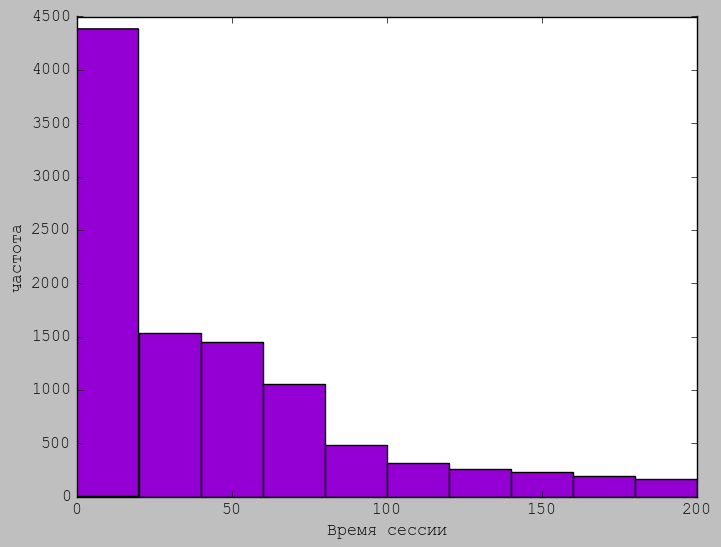

In [171]:
#import matplotlib
#matplotlib.rc('font', family='Verdana')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'fantasy'
mpl.rcParams['font.fantasy'] = 'Arial' # Для Windows

from matplotlib import rc
mpl.rcdefaults() # сброс настроек  
font = {'family': 'Courier New',
        'weight': 'normal'}
rc('font', **font)


import matplotlib.pyplot as plt

ax = plt.axes()
ax.hist(train_data_10users['session_timespan'],range=(0,200), color='darkviolet')
ax.set_xlabel(u'Время сессии')
ax.set_ylabel(u'частота')



**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

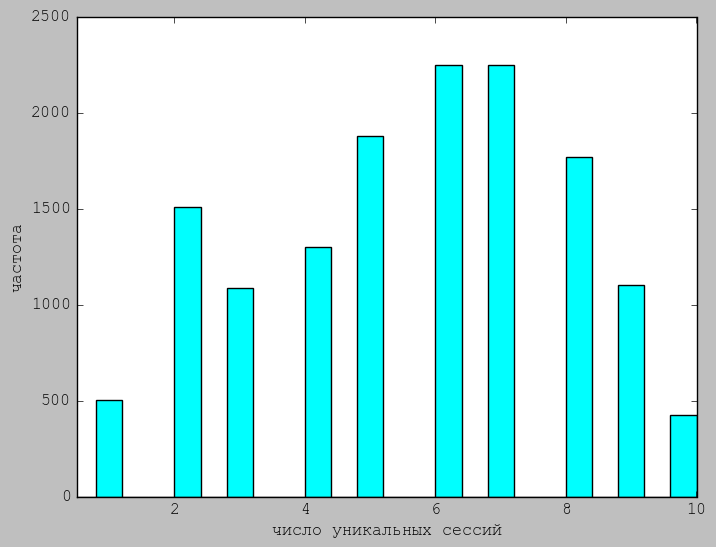

In [48]:
plt.hist(train_data_10users['#unique_sites'], 25,  color='aqua')
plt.xlim((0.5,10))
plt.xlabel(u'число уникальных сессий')
plt.ylabel(u'частота')
plt.show()


**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

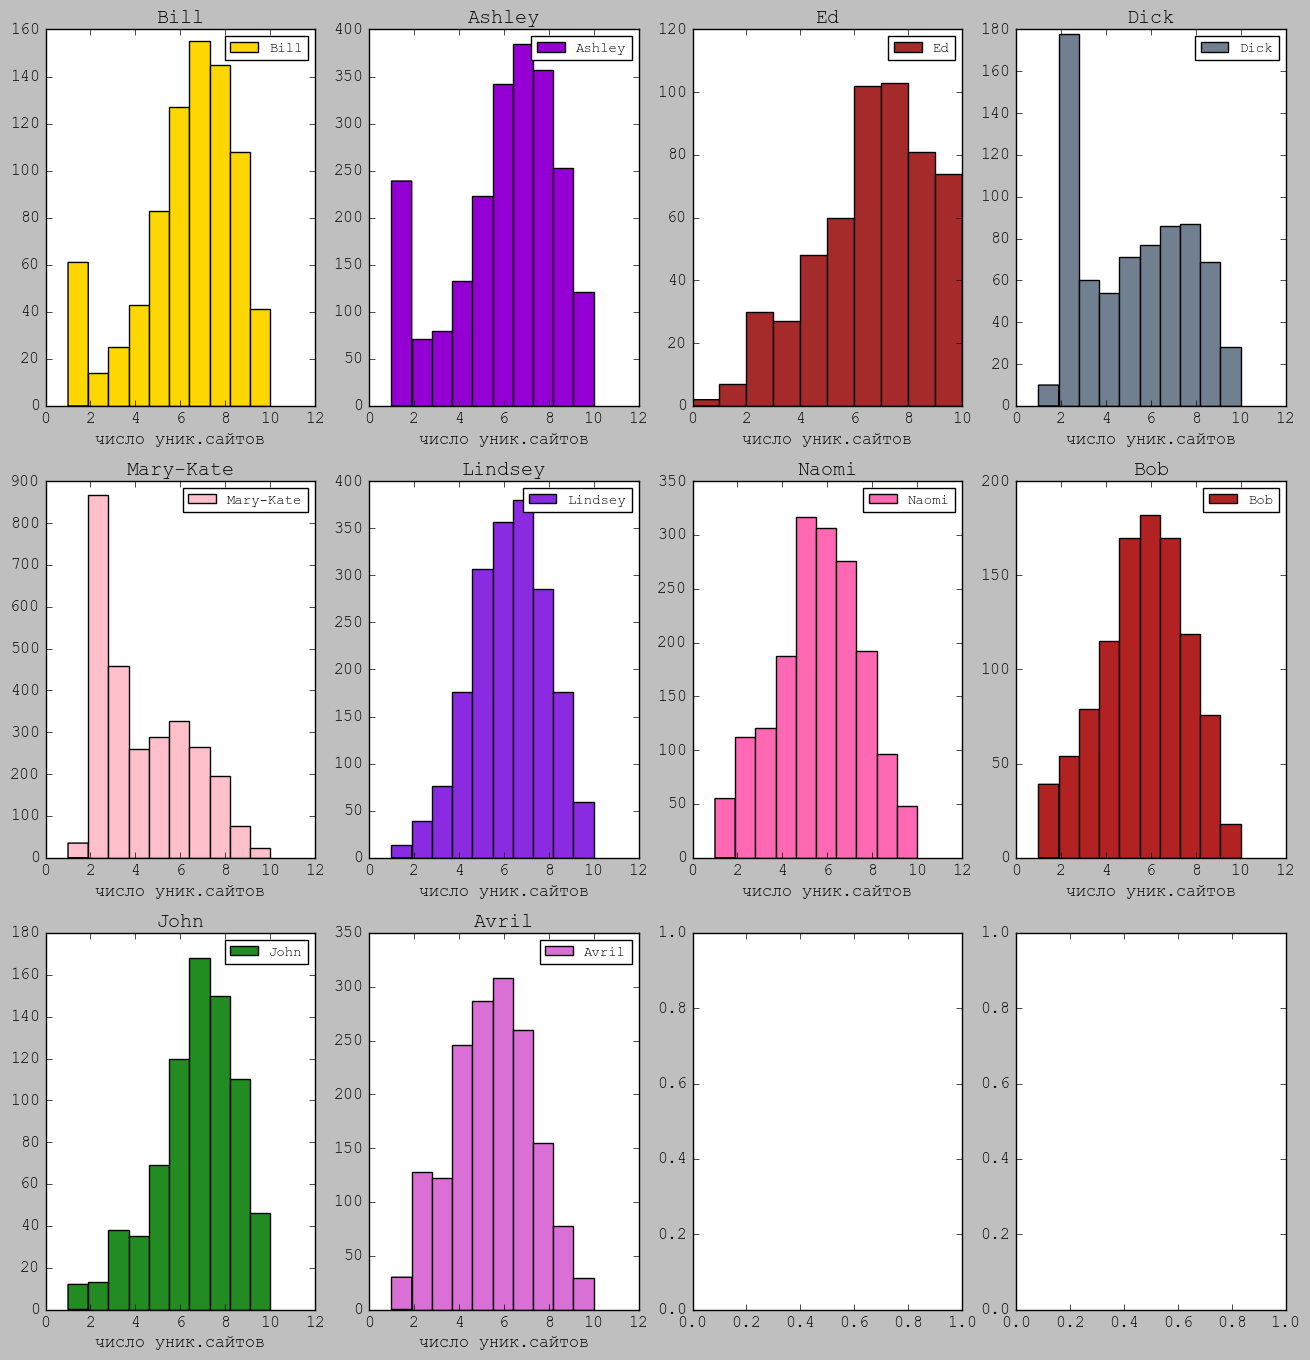

In [62]:
#train_data_10users.hist(by='target', column='#unique_sites',  layout=(3,4))   
    

for_plot1= train_data_10users[['target','#unique_sites']]
grouped = pd.groupby(for_plot1, 'target')
fig, axs = plt.subplots(figsize=(16,16),   nrows=3, ncols=4) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key)['#unique_sites'],color=color_dic[key],label=key)
    ax.set_title(key)
    ax.legend(prop={'size': 10})
    ax.set_xlabel(u'число уник.сайтов')
    
    
plt.show()
                      


**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

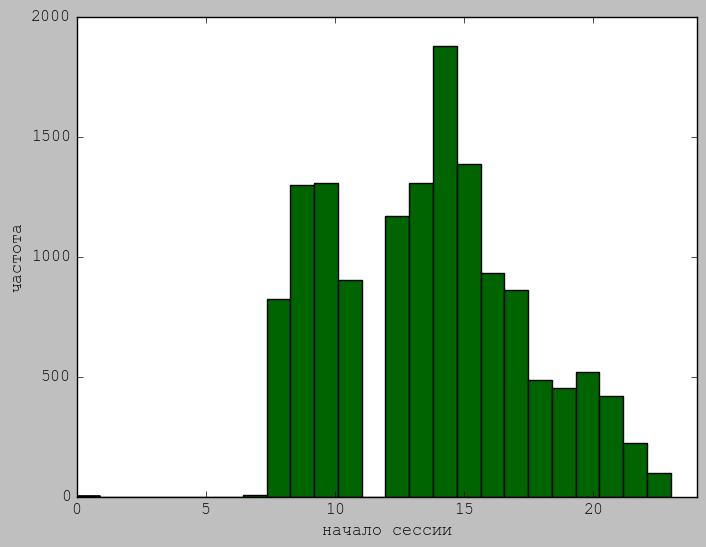

In [50]:
plt.hist(train_data_10users['start_hour'], 25,  color='darkgreen')
plt.xlim((0,24))
plt.xlabel(u'начало сессии')
plt.ylabel(u'частота')
plt.show()


**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

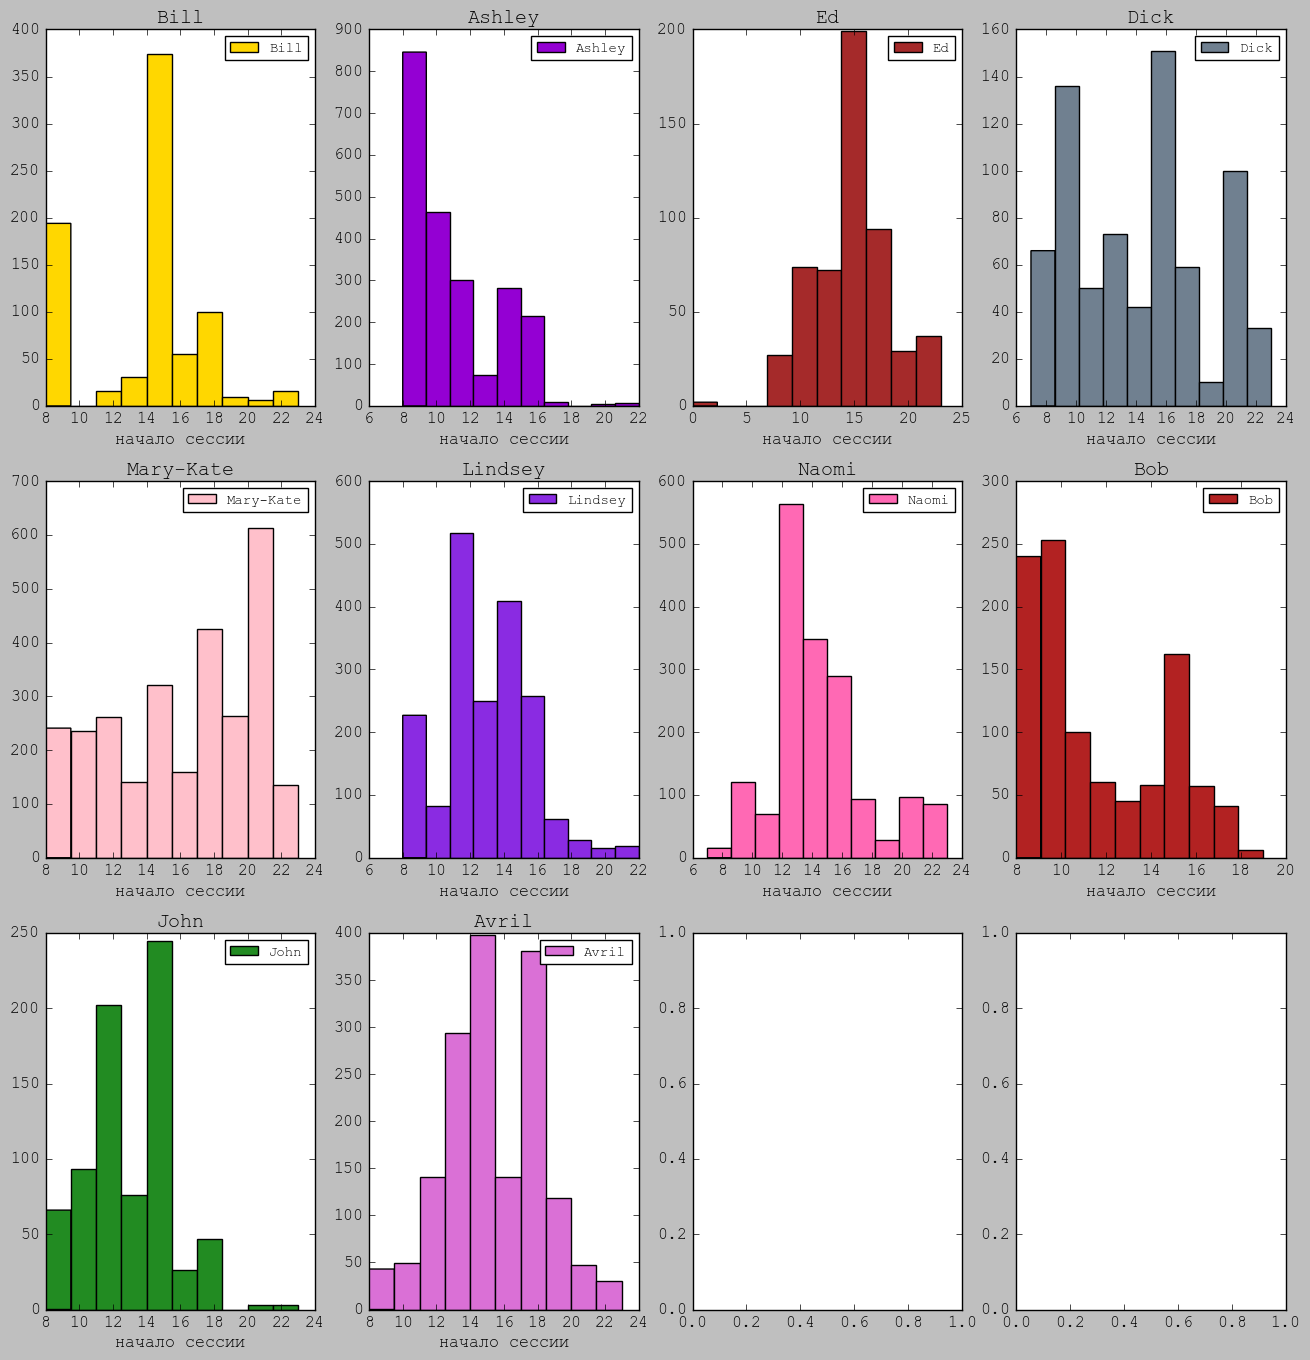

In [63]:
for_plot2= train_data_10users[['target','start_hour']]
grouped = pd.groupby(for_plot2, 'target')
fig, axs = plt.subplots(figsize=(16,16),   nrows=3, ncols=4) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key)['start_hour'],color=color_dic[key],label=key)
    ax.set_title(key)
    ax.legend(prop={'size': 10})
    ax.set_xlabel(u'начало сессии')
    
    
plt.show()


**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

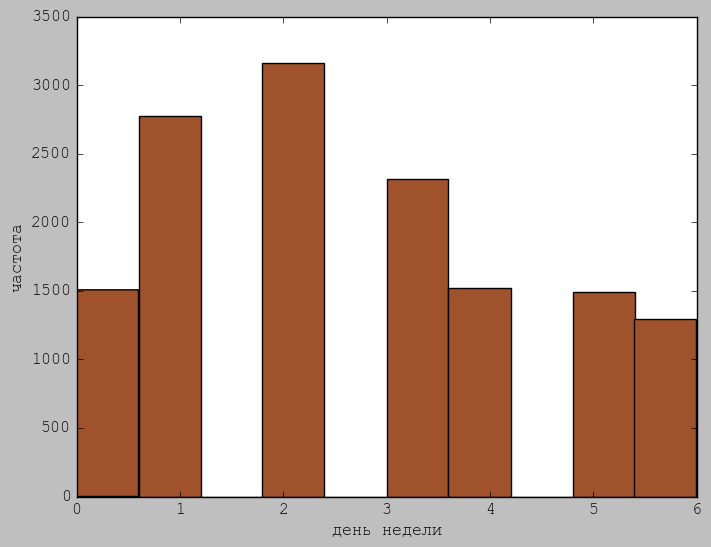

In [52]:
plt.hist(train_data_10users['day_of_week'],   color='sienna')
plt.xlabel(u'день недели')
plt.ylabel(u'частота')
plt.show()



**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

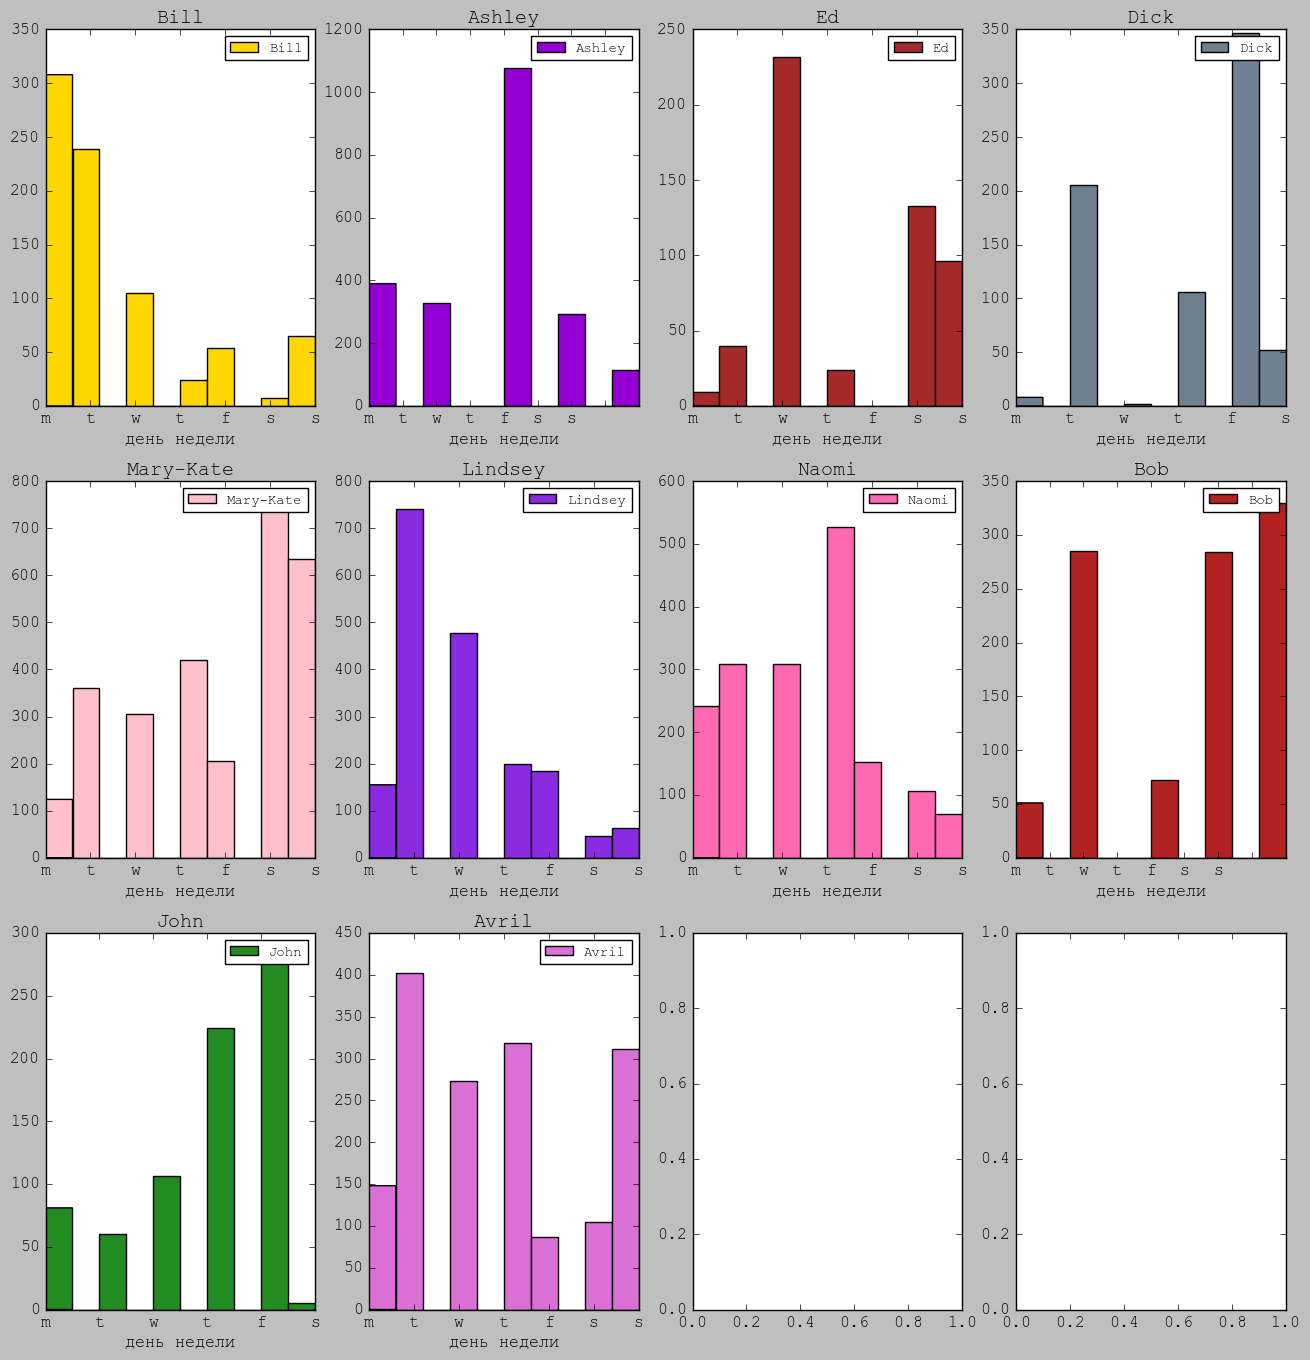

In [59]:
for_plot3= train_data_10users[['target','day_of_week']]
grouped = pd.groupby(for_plot3, 'target')
fig, axs = plt.subplots(figsize=(16,16),   nrows=3, ncols=4) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key)['day_of_week'],color=color_dic[key], label=key)
    ax.set_title(key)
    ax.legend(prop={'size': 10})
    ax.set_xlabel(u'день недели')
    ax.set_xticklabels('mtwtfss')
    
    
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**выводы:**

Минимальный час сессии сам по себе не является хорошим маркером, разделяющим субъектов, поскольку большинство активно с 8 (или чуть раньше) до конца рабочего дня. Однако, частота сессий в определенных час может быть значимым маркером.
Гистограммы для числа уникальных сессий достаточно схожи между собой. За ислючением 3 случаев с сильным выбросом на 1 или 2 сайта. Возможно, в это случае мы наблудали просто короткие сессии. и изменение длины окна сгладит эту проблему. Или дело в некоторой специфичной активности пользователя?
Сочетание для недели и времени должно быть хорошим маркером, так как висно что некоторые пользователи более активны по выходным.

Bill,  вероятно, проверят несколько новостных сайтов в 8 утра, второй пик в середине дня. активен в интернете в начале недели просматрвает довольно много различных сайтов, но выделяется один, который он посещает чаще всего;
Ashley часто посещает один сайт, который как-то связан с одновной деятельностью.
Еd посещает различные сайты, в основном после обеда.
Dick не выгодит в интернете в понедельник. Пик активности приходится на утро и послеобеденное время. есть 2 любимых сайта
Mary-Kate часто посещает  1-2 сайта, в основном вечером или преимущественно по выходным.
Lindsey меньше активна к конву недели. Посещает сайты в обеденное время.
Naomi активна в середине дня, много уникальных сайтов в сессии.
Bob  не бывает в интернете по выходным. посещает сайты с 0 до конца рабочего дня,
John активен с утра и до обеда. много уникалæных сайтов.
Avril активна в обеденное время. половина сайтов сессии уникальна.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [64]:
with open('capstone_websites_data/site_freq_10users.pkl', 'rb') as site_freq10:
    site_freq = pickle.load(site_freq10)


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [105]:
##использован словарь 1, где учтены сессии с дубликатами
top10_info = [v for k,v in sorted(site_freq.items(), key=lambda x: x[1][1], reverse=True)[:10]]
top10_freqs = [x[1] for x in top10_info]

top10_popular = [k for k,v in sorted(site_freq.items(), key=lambda x: x[1][1], reverse=True)[:10]]
print([k for k,v in sorted(site_freq.items(), key=lambda x: x[1][1], reverse=True)[:30]])
print([v for k,v in sorted(site_freq.items(), key=lambda x: x[1][1], reverse=True)[:30]])


['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com', 'r2---sn-gxo5uxg-jqbe.googlevideo.com', 'fr-mg42.mail.yahoo.com', 'www.youtube.com', 'r4---sn-gxo5uxg-jqbe.googlevideo.com', 'clients1.google.com', 'download.jboss.org', 's-static.ak.facebook.com', 'static.ak.facebook.com', 'i1.ytimg.com', 'twitter.com', 'accounts.youtube.com', 'platform.twitter.com', 'safebrowsing-cache.google.com', 'clients6.google.com', 'translate.google.fr', 'api.twitter.com', 'accounts.google.fr', 'talkgadget.google.com', 'mts0.google.com', 'clients2.google.com']
[(209, 8300), (51, 7813), (8, 5441), (183, 4158), (3, 4141), (129, 3758), (700, 3244), (213, 3094), (188, 2630), (184, 2089), (699, 1939), (627, 1868), (204, 1804), (208, 1702), (568, 1493), (1789, 1441), (130, 1388), (64, 1265), (205, 1232), (131, 1204), (185, 1057), (68, 104

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

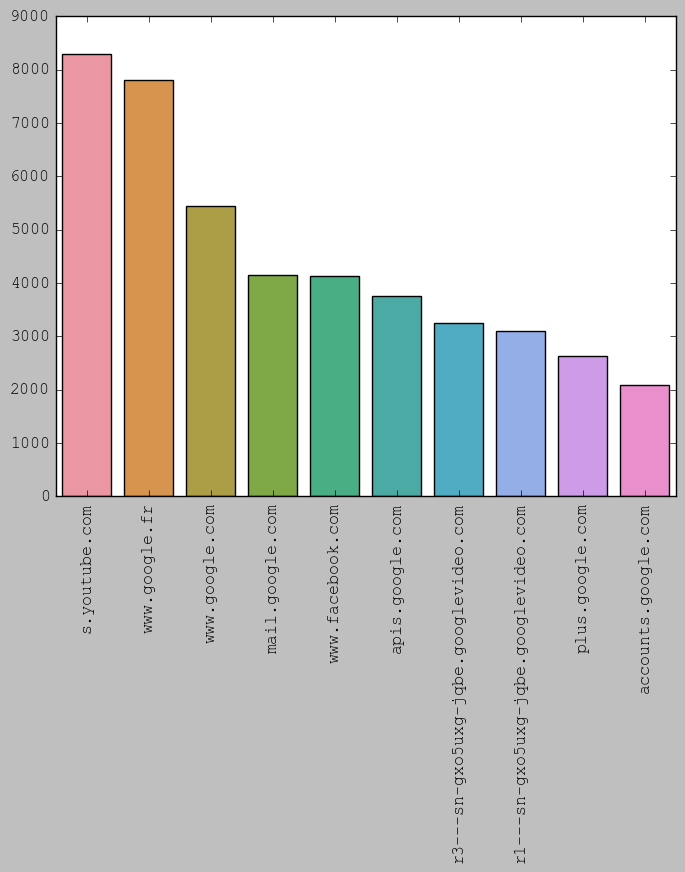

In [103]:
import seaborn as sns
p=sns.barplot(x=top10_popular, y=top10_freqs)
for item in p.get_xticklabels():
    item.set_rotation(90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [122]:
def feature_engineering(csv_files_mask, features, session_length=10):
    
    import glob
    window_size=10
    files = glob.glob(csv_files_mask) 
    dfs = []
    for filename in files:
        dfs.append(pd.read_csv(filename, header=None, names=['id', 'timestamp', 'site']))
    # Concatenate all data into one DataFrame
    users = pd.concat(dfs, ignore_index=True)
    
    ##load dict 
    #with open(site_freq_path, 'rb') as site_freq:
    #    dict_freq1 = pickle.load(site_freq)

    
    ##create dict with freq
    import collections
    sitesnames = users['site']
    un = np.unique(np.array(sitesnames) , return_index=True, return_inverse = True, return_counts = True)
    indexes = un[1]
    unlist = [sitesnames [index] for index in sorted(indexes)] 
    counts = un[3][[un[2][index] for index in sorted(np.unique(un[2],return_index=True)[1])] ]
    from collections import OrderedDict
    dict_freq0 = OrderedDict(zip(unlist, zip(range(1,(len(unlist)+1) ),  counts) ) )
    dict_freq1 = dict(zip(unlist, zip(range(1,(len(unlist)+1) ),  counts) ) )

    
    from datetime import datetime
    import datetime as dt
    ##create session matr
    id_session = []
    for i in np.unique(users['id']):
        leng = users['id'][(users['id']==i)]
        id_session = np.concatenate((id_session, [i]*((len(leng)//session_length)+1)),axis = 0 )
    session_matr = np.zeros(((len(id_session),session_length) ) )
    #session_matr[:,session_length] = id_session
    session_matr_fe= np.zeros(((len(id_session),len(features)+1 ) ))    
    session_matr_fe[:,(len(features))] = id_session
    prev = 0
    y_coord = 0
    for i in np.unique(users['id']):
        leng = users['id'][(users['id']==i)]
        for ind in range(0,len(leng)) :
            x_coord = ind % session_length
            y_coord = ind //session_length 
            session_matr[(y_coord+prev), x_coord] = dict_freq1[users['site'][leng.index[ind] ]][0]     
        prev = prev + y_coord + 1

        
    ##create features matr
    prev = 0
    y_coord = 0
    for i in np.unique(users['id']):
        leng = users['id'][(users['id']==i)]
        indexes = np.where((users['id']==i))   
        for ind in range(0,len(leng)) :
            x_coord = ind % session_length
            y_coord = ind //session_length 
            # print(dict_freq1[users['site'][leng.index[ind] ]])  
            if (x_coord>0):
                start_dt = dt.datetime.strptime(users['timestamp'][indexes[0][(ind-1)] ], "%Y-%m-%dT%H:%M:%S")#.time()
                end_dt =dt.datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S")#.time()
                diff = (end_dt - start_dt)
                #session_matr_fe[(y_coord+prev), (x_coord-1)] =int(diff.seconds)
                
                min_day = min(min_day,datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S") )
                max_day = max(max_day,datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S") )
                #session_matr_fe[(y_coord+prev), session_length+1] = min_day.hour 
                #session_matr_fe[(y_coord+prev), session_length+2] =min_day.weekday()
            
            else:
                min_day = datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S")
                max_day = datetime.strptime(users['timestamp'][indexes[0][ind] ], "%Y-%m-%dT%H:%M:%S")
                #session_matr_fe[(y_coord+prev), (session_length-1)] = -20
                #session_matr_fe[(y_coord+prev), session_length] = 1
                #session_matr_fe[(y_coord+prev), session_length+1] = min_day.hour
                #session_matr_fe[(y_coord+prev), session_length+2] = min_day.weekday()
         
            if (x_coord == 9):
                                
                ind1=dict_freq1.values()[dict_freq1.keys().index('www.facebook.com')][0]
                ind2=dict_freq1.values()[dict_freq1.keys().index('static.ak.facebook.com')][0]
                session_matr_fe[(y_coord+prev), 0] = sum(sum([session_matr[(y_coord+prev), : ]== ind1]*1) )+sum(sum([session_matr[(y_coord+prev), : ]== ind2]*1) )
                ind1=dict_freq1.values()[dict_freq1.keys().index('s.youtube.com')][0]
                ind2=dict_freq1.values()[dict_freq1.keys().index('www.youtube.com')][0]
                session_matr_fe[(y_coord+prev), 1] = sum(sum([session_matr[(y_coord+prev), : ]== ind1]*1) )+sum(sum([session_matr[(y_coord+prev), : ]== ind2]*1) )
                ind1=dict_freq1.values()[dict_freq1.keys().index('twitter.com')][0]
                ind2=dict_freq1.values()[dict_freq1.keys().index('platform.twitter.com')][0]
                session_matr_fe[(y_coord+prev), 2] = sum(sum([session_matr[(y_coord+prev), : ]== ind1]*1) )+sum(sum([session_matr[(y_coord+prev), : ]== ind2]*1) )
                       
            else:
                if (session_matr[(y_coord+prev),(x_coord+1)]==0):
                    ##fb 3 and 64, yt 209 204, tw 131,68,1599
                    ind1=dict_freq1.values()[dict_freq1.keys().index('www.facebook.com')][0]
                    ind2=dict_freq1.values()[dict_freq1.keys().index('static.ak.facebook.com')][0]
                    session_matr_fe[(y_coord+prev), 0] = sum(sum([session_matr[(y_coord+prev), : ]== ind1]*1) )+sum(sum([session_matr[(y_coord+prev), : ]== ind2]*1) )
                    ind1=dict_freq1.values()[dict_freq1.keys().index('s.youtube.com')][0]
                    ind2=dict_freq1.values()[dict_freq1.keys().index('www.youtube.com')][0]
                    session_matr_fe[(y_coord+prev), 1] = sum(sum([session_matr[(y_coord+prev), : ]== ind1]*1) )+sum(sum([session_matr[(y_coord+prev), : ]== ind2]*1) )
                    ind1=dict_freq1.values()[dict_freq1.keys().index('twitter.com')][0]
                    ind2=dict_freq1.values()[dict_freq1.keys().index('platform.twitter.com')][0]
                    session_matr_fe[(y_coord+prev), 2] = sum(sum([session_matr[(y_coord+prev), : ]== ind1]*1) )+sum(sum([session_matr[(y_coord+prev), : ]== ind2]*1) )
                
        prev = prev + y_coord + 1
        
    ##new dict based on unique sessions
    new1 = pd.DataFrame(session_matr).drop_duplicates(keep='first')    
    counts = new1.stack().value_counts().to_dict()
    try:
        del counts[counts.keys()[0]]
    except KeyError:
        pass

    output = pd.DataFrame(session_matr_fe)
    output.columns = features+['target']
    return(output)


In [134]:
new_feature_names =    ['FB','Youtube','Tw']
#feature_engineering('capstone_websites_data/3users_toy/*', features = new_feature_names , session_length=10)
new_features_10users =feature_engineering('capstone_websites_data/10users/*', features = new_feature_names , session_length=10)
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [126]:
new_features_150users = feature_engineering('capstone_websites_data/10users/*', features = new_feature_names , session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**


Индикатор для посещения фейсбука не является хорошим маркером, однако оба индикатора для Ютуба и Твиттера позволяют уловить уникальные паттерны поведения.

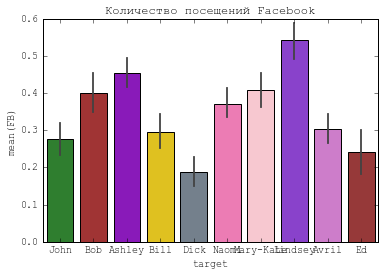

In [163]:
p1=sns.barplot(x="target",y= "FB",data=new_features_10users,palette = color_dic)
sns.plt.title(u'Количество посещений Facebook')


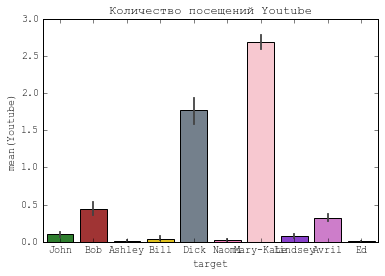

In [164]:
p2=sns.barplot(x="target",y= "Youtube",data=new_features_10users,palette = color_dic)
sns.plt.title(u'Количество посещений Youtube')


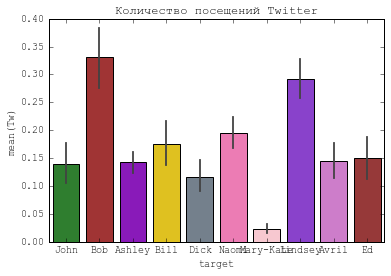

In [149]:
p3=sns.barplot(x="target",y= "Tw",data=new_features_10users,palette = color_dic)
sns.plt.title(u'Количество посещений Twitter')

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [162]:
selected_features_10users = pd.concat([train_data_10users[['session_timespan','time_diff1','time_diff2','time_diff3','time_diff4','time_diff5','time_diff6','time_diff7','time_diff8','time_diff9','#unique_sites','start_hour','day_of_week']],new_features_10users])
selected_features_150users = pd.concat([train_data_150users[['session_timespan','time_diff1','time_diff2','time_diff3','time_diff4','time_diff5','time_diff6','time_diff7','time_diff8','time_diff9','#unique_sites','start_hour','day_of_week']],new_features_150users])


In [145]:
# selected features – among (session_timespan, ..., day_of_week) and your own new ones
with open('selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open('selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя проекта посвящена общему описанию проекта (.ipynb или pdf) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящая [статья](https://habrahabr.ru/post/308162/) по этому ремеслу)
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями, не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

Далее пройдите чисто техническое задание "Проверка построенных признаков", цель которого – удостовериться, что все мы одинаково создали признаки *session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour* и *day_of_week*.